In [1]:
import json

from pymongo import MongoClient

import numpy as np
import matplotlib.pyplot as plt
import line_profiler

from helpers import *
from imputation import *

client = MongoClient("localhost", 27017)
db = client['usgs']
%matplotlib inline

In [ ]:
def extreme_values(y, continuity, high = True, low = True):
    n = y.size // 2
    res = y.copy()
    
    z = np.sort(np.abs(y))
    dz = z[1:] - z[:-1]
    
    if low:
        mask_min = dz[:n][::-1] > continuity
        if mask_min.sum() > 0:
            i_min = n - np.argmax(dz[:n][::-1] > continuity)
            thr_min = 0.5*(z[i_min] + z[i_min - 1])
        else:
            thr_min = z[0] - 1
    else:
        thr_min = z[0] - 1
        
    if high:
        mask_max = dz[n:] > continuity
        if mask_max.sum() > 0:
            i_max = n + np.argmax(dz[n:] > continuity)
            thr_max = 0.5*(z[i_max] + z[i_max + 1])
        else:
            thr_max = z[-1] + 1   
    else:
        thr_max = z[-1] + 1  
    
    idx = np.logical_or(res < thr_min, res > thr_max)
    return idx


def detect_spikes(y, min_amp = 0.5, thr = 0.25):
    mask = np.zeros(y.size, dtype = bool)
    for i in range(1, y.size - 1):
        dL = ( y[i] - y[i-1] ) / dt * 3600
        dR = ( y[i] - y[i+1] ) / dt * 3600 
        
        absL = abs(dL)
        absR = abs(dR)
        
        d = abs(absL - absR)
        
        if ( dL * dR > 0 ) and ( absL > min_amp ) and ( absR > min_amp ) and ( d < thr * max(absL, absR) ) :
            mask[i] = True
            
    return mask


def fix_spikes(y, mask):
    z = y.copy()
    idx = np.where(mask)[0]
    z[idx] = 0.5*(y[idx - 1] + y[idx + 1])
    return z

In [ ]:
sid = json.load(open('revision_list_d.json'))['to_review']

In [ ]:
# mis-alignment
2198000, 2422500, 2318700, 15743850

In [ ]:
good = [5124480, 2378500, 11057500, 6061500, 9447800, 2361000, 1022500, 3550000, 2329500, 11152000, 1372500, 3049000, 
        12043300, 10293000, 1193500, 9124500]

In [ ]:
e_raw = np.zeros(len(sid)) - 1
e_new = np.zeros(len(sid)) - 1

In [ ]:
si = 0
t_raw, z_raw, t_true, z_true = get_data(db, sid[si])
z_raw  = feet_to_meters(z_raw)
z_true = feet_to_meters(z_true)
dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)
print(sid[si], dt)

In [ ]:
for si in range(len(sid)):
    try:
        t_raw, z_raw, t_true, z_true = get_data(db, sid[si])
    except:
        continue
    
    z_raw  = feet_to_meters(z_raw)
    z_true = feet_to_meters(z_true)
    dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)
    
    if dt < 300:
        continue

    z = z_raw.copy()
    mask = extreme_values(z, continuity = 0.13, high = True, low = True)
    z[mask] = -1

    z = fill_gaps(z,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    dt, y_new, _ = align_measurements(t_raw, z, t_true, z_true)

    y_raw  = fill_gaps(y_raw,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    y_true = fill_gaps(y_true, max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    y_new  = fill_gaps(y_new,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)

    is_spike = detect_spikes(y_new, min_amp = 0.5, thr = 0.25)
    y_new = fix_spikes(y_new, is_spike)

    e_raw[si] = xae(y_raw, y_true)
    e_new[si] = xae(y_new, y_true)
    
    print(sid[si], '\t%.4f  \t%.4f' % (e_raw[si], e_new[si]))

In [ ]:
diff = e_raw - e_new
mask = np.logical_not(np.logical_or(np.isnan(e_raw), np.isnan(e_new)))
sorted(list(zip(diff[diff < 0], np.array(sid)[diff < 0])))

In [ ]:
t_raw, z_raw, t_true, z_true = get_data(db, 9418500)

z_raw  = feet_to_meters(z_raw)
z_true = feet_to_meters(z_true)
dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)

z = z_raw.copy()
mask = extreme_values(z, continuity = 0.13, high = True, low = True)
z[mask] = -1

z = fill_gaps(z,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
dt, y_new, _ = align_measurements(t_raw, z, t_true, z_true)

y_raw  = fill_gaps(y_raw,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
y_true = fill_gaps(y_true, max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
y_new  = fill_gaps(y_new,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)

is_spike = detect_spikes(y_new, min_amp = 0.5, thr = 0.25)
y_new = fix_spikes(y_new, is_spike)

plt.figure(figsize = (16,4))
plt.plot(y_raw, 'b-')
#plt.plot(y_true, 'g-')
plt.plot(y_new, 'r.-')
#plt.xlim(106000, 108000)

In [ ]:
cursor = db['cites'].find()

X_raw = list()
X_true = list()

n_in = 1024

for c in cursor:
    sid = c['site_no']
    try:
        t_raw, z_raw, t_true, z_true = get_data(db, sid)
    except:
        continue
        
    z_raw  = feet_to_meters(z_raw)
    z_true = feet_to_meters(z_true)
    dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)
    
    if dt != 900:
        continue

    y_raw  = fill_gaps(y_raw,  max_gap = 7 * 86400 // dt, spike_size = 2, window_size = 10)
    y_true = fill_gaps(y_true, max_gap = 7 * 86400 // dt, spike_size = 2, window_size = 10)
    
    if y_raw.size > n_in:
        X_raw.append(y_raw[:n_in])
        X_true.append(y_true[:n_in])
        
X_raw = np.array(X_raw, dtype = np.float32)
X_true = np.array(X_true, dtype = np.float32)

X_raw  = X_raw.reshape(X_raw.shape[0], X_raw.shape[1], 1)
X_true = X_true.reshape(X_true.shape[0], X_true.shape[1], 1)

In [2]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Activation, Flatten
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, AveragePooling1D
from keras.optimizers import RMSprop, Adam

Using Theano backend.
Using gpu device 0: GeForce GTS 450 (CNMeM is disabled, cuDNN not available)
/home/dlevin/anaconda3/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [28]:
n = 1024
N = 1000
t = np.linspace(-np.pi, np.pi, n)

X = np.zeros((N, n, 1))
Y = np.zeros((N, n))

for i in range(N):
    x = np.random.randn() * np.sin(np.random.randn()*t + np.random.randn()) + 0.02*np.random.randn(n)

    y = x.copy()
    i = np.random.randint(0, n//2 - 1)
    j = np.random.randint(0, n//3 - 1)
    y[i:i+j] += 2*y.max() + np.random.randn()
    idx = np.random.choice(np.arange(n), 32, replace = False)
    y[idx] += 2*y.max() + np.random.randn(idx.size)
    
    X[i, :, 0] = x
    Y[i, :] = x

In [29]:
model = Sequential()

model.add(Convolution1D(nb_filter = 16, filter_length = 3, activation = 'relu', input_shape = (n, 1), init = 'lecun_uniform'))

model.add(Convolution1D(nb_filter = 32, filter_length = 5, activation = 'relu', init = 'lecun_uniform'))

model.add(Convolution1D(nb_filter = 64, filter_length = 5, activation = 'relu', init = 'lecun_uniform'))

model.add(MaxPooling1D(pool_length = 4))

model.add(Convolution1D(nb_filter = 64, filter_length = 5, activation = 'relu', init = 'lecun_uniform'))

model.add(MaxPooling1D(pool_length = 3))

model.add(Flatten())

model.add(Dense(n // 4, activation = 'relu'))

model.add(Dense(n, activation = 'linear'))

opt = Adam(lr = 1e-3)
model.compile(optimizer = opt, loss = 'mse')

In [30]:
model.fit(X, Y, 
          nb_epoch = 100, 
          verbose = 2, 
          batch_size = 64)

Epoch 1/100
4s - loss: 0.1571
Epoch 2/100
4s - loss: 0.0436
Epoch 3/100
4s - loss: 0.0183
Epoch 4/100
4s - loss: 0.0124
Epoch 5/100
4s - loss: 0.0085
Epoch 6/100
4s - loss: 0.0055
Epoch 7/100
4s - loss: 0.0042
Epoch 8/100
4s - loss: 0.0034
Epoch 9/100
4s - loss: 0.0025
Epoch 10/100
4s - loss: 0.0027
Epoch 11/100
4s - loss: 0.0023
Epoch 12/100
4s - loss: 0.0022
Epoch 13/100
4s - loss: 0.0025
Epoch 14/100
4s - loss: 0.0020
Epoch 15/100
4s - loss: 0.0025
Epoch 16/100
4s - loss: 0.0018
Epoch 17/100
4s - loss: 0.0015
Epoch 18/100
4s - loss: 0.0014
Epoch 19/100
4s - loss: 0.0012
Epoch 20/100
4s - loss: 0.0011
Epoch 21/100
4s - loss: 0.0010
Epoch 22/100
4s - loss: 0.0015
Epoch 23/100
4s - loss: 0.0016
Epoch 24/100
4s - loss: 0.0018
Epoch 25/100
4s - loss: 0.0021
Epoch 26/100
4s - loss: 0.0017
Epoch 27/100
4s - loss: 0.0015
Epoch 28/100
4s - loss: 0.0015
Epoch 29/100
4s - loss: 0.0022
Epoch 30/100
4s - loss: 0.0014
Epoch 31/100
4s - loss: 9.4549e-04
Epoch 32/100
4s - loss: 7.4606e-04
Epoch 33/

KeyboardInterrupt: 

In [ ]:
y_pred = model.predict(X)

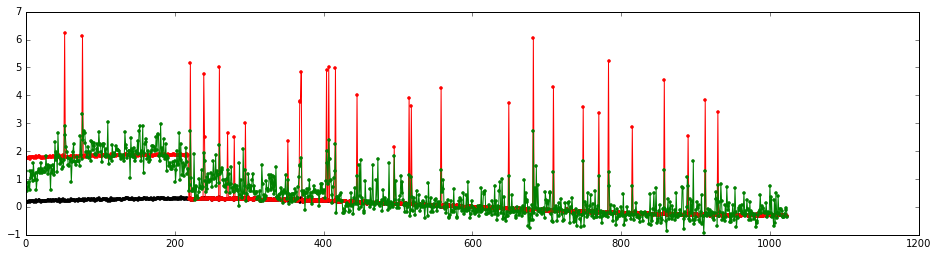

In [26]:
i = 0
plt.figure(figsize = (16,4))
plt.plot(X[i,:,0],  'k.-')
plt.plot(Y[i],      'r.-')
plt.plot(y_pred[i], 'g.-')